# This is Lab 4 executable file

This file contains the program code that is the solution to the tasks from the file [lab_4_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_4/lab_4_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [178]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from scipy import signal
from datetime import datetime
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa import stattools

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams


## Exercise №1

Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [127]:
# Load dataset
path_to_file = '../Datasets/timeStamped_Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.head(10)

# Aggregation

# Proccess Timestamps
source_df['timeStamp']=pd.to_datetime(source_df['timeStamp'], format='%Y-%m-%d %H:%M:%S')
source_df['timeStamp']=source_df['timeStamp'].dt.round('3h') 

# Choose varioables
# target:
target_cols = ["blueTotalHeal", "blueTotalGold"]
# predictors:
pred_cols = ["gameDuraton", "blueChampionDamageDealt"]

col_names = target_cols + pred_cols

df_agged=source_df.groupby('timeStamp', as_index=False).agg({"blueTotalHeal": "mean", "blueTotalGold": "mean", "gameDuraton": "mean", "blueChampionDamageDealt": "mean"})
df_agged=df_agged.sort_values('timeStamp')
df_agged.head(10)

,timeStamp,blueTotalHeal,blueTotalGold,gameDuraton,blueChampionDamageDealt
0,2019-01-03 18:00:00,18.092000,43.865000,23.900000,57.547000
1,2019-01-05 18:00:00,35.028667,51.676000,26.477778,72.211333
2,2019-01-07 18:00:00,20.913333,46.317333,22.594444,51.522333
3,2019-01-08 15:00:00,21.567000,60.554000,26.416667,94.014000
4,2019-01-08 18:00:00,45.280000,78.178000,37.250000,114.909000
5,2019-01-11 18:00:00,24.877500,48.762000,24.225000,60.525500
6,2019-01-12 18:00:00,31.983000,70.050000,31.500000,110.272000
7,2019-01-13 15:00:00,5.726000,40.619000,23.233333,54.175000
8,2019-01-14 12:00:00,16.576000,33.484000,15.333333,26.938000
9,2019-01-14 15:00:00,29.339000,52.979000,27.550000,80.685000


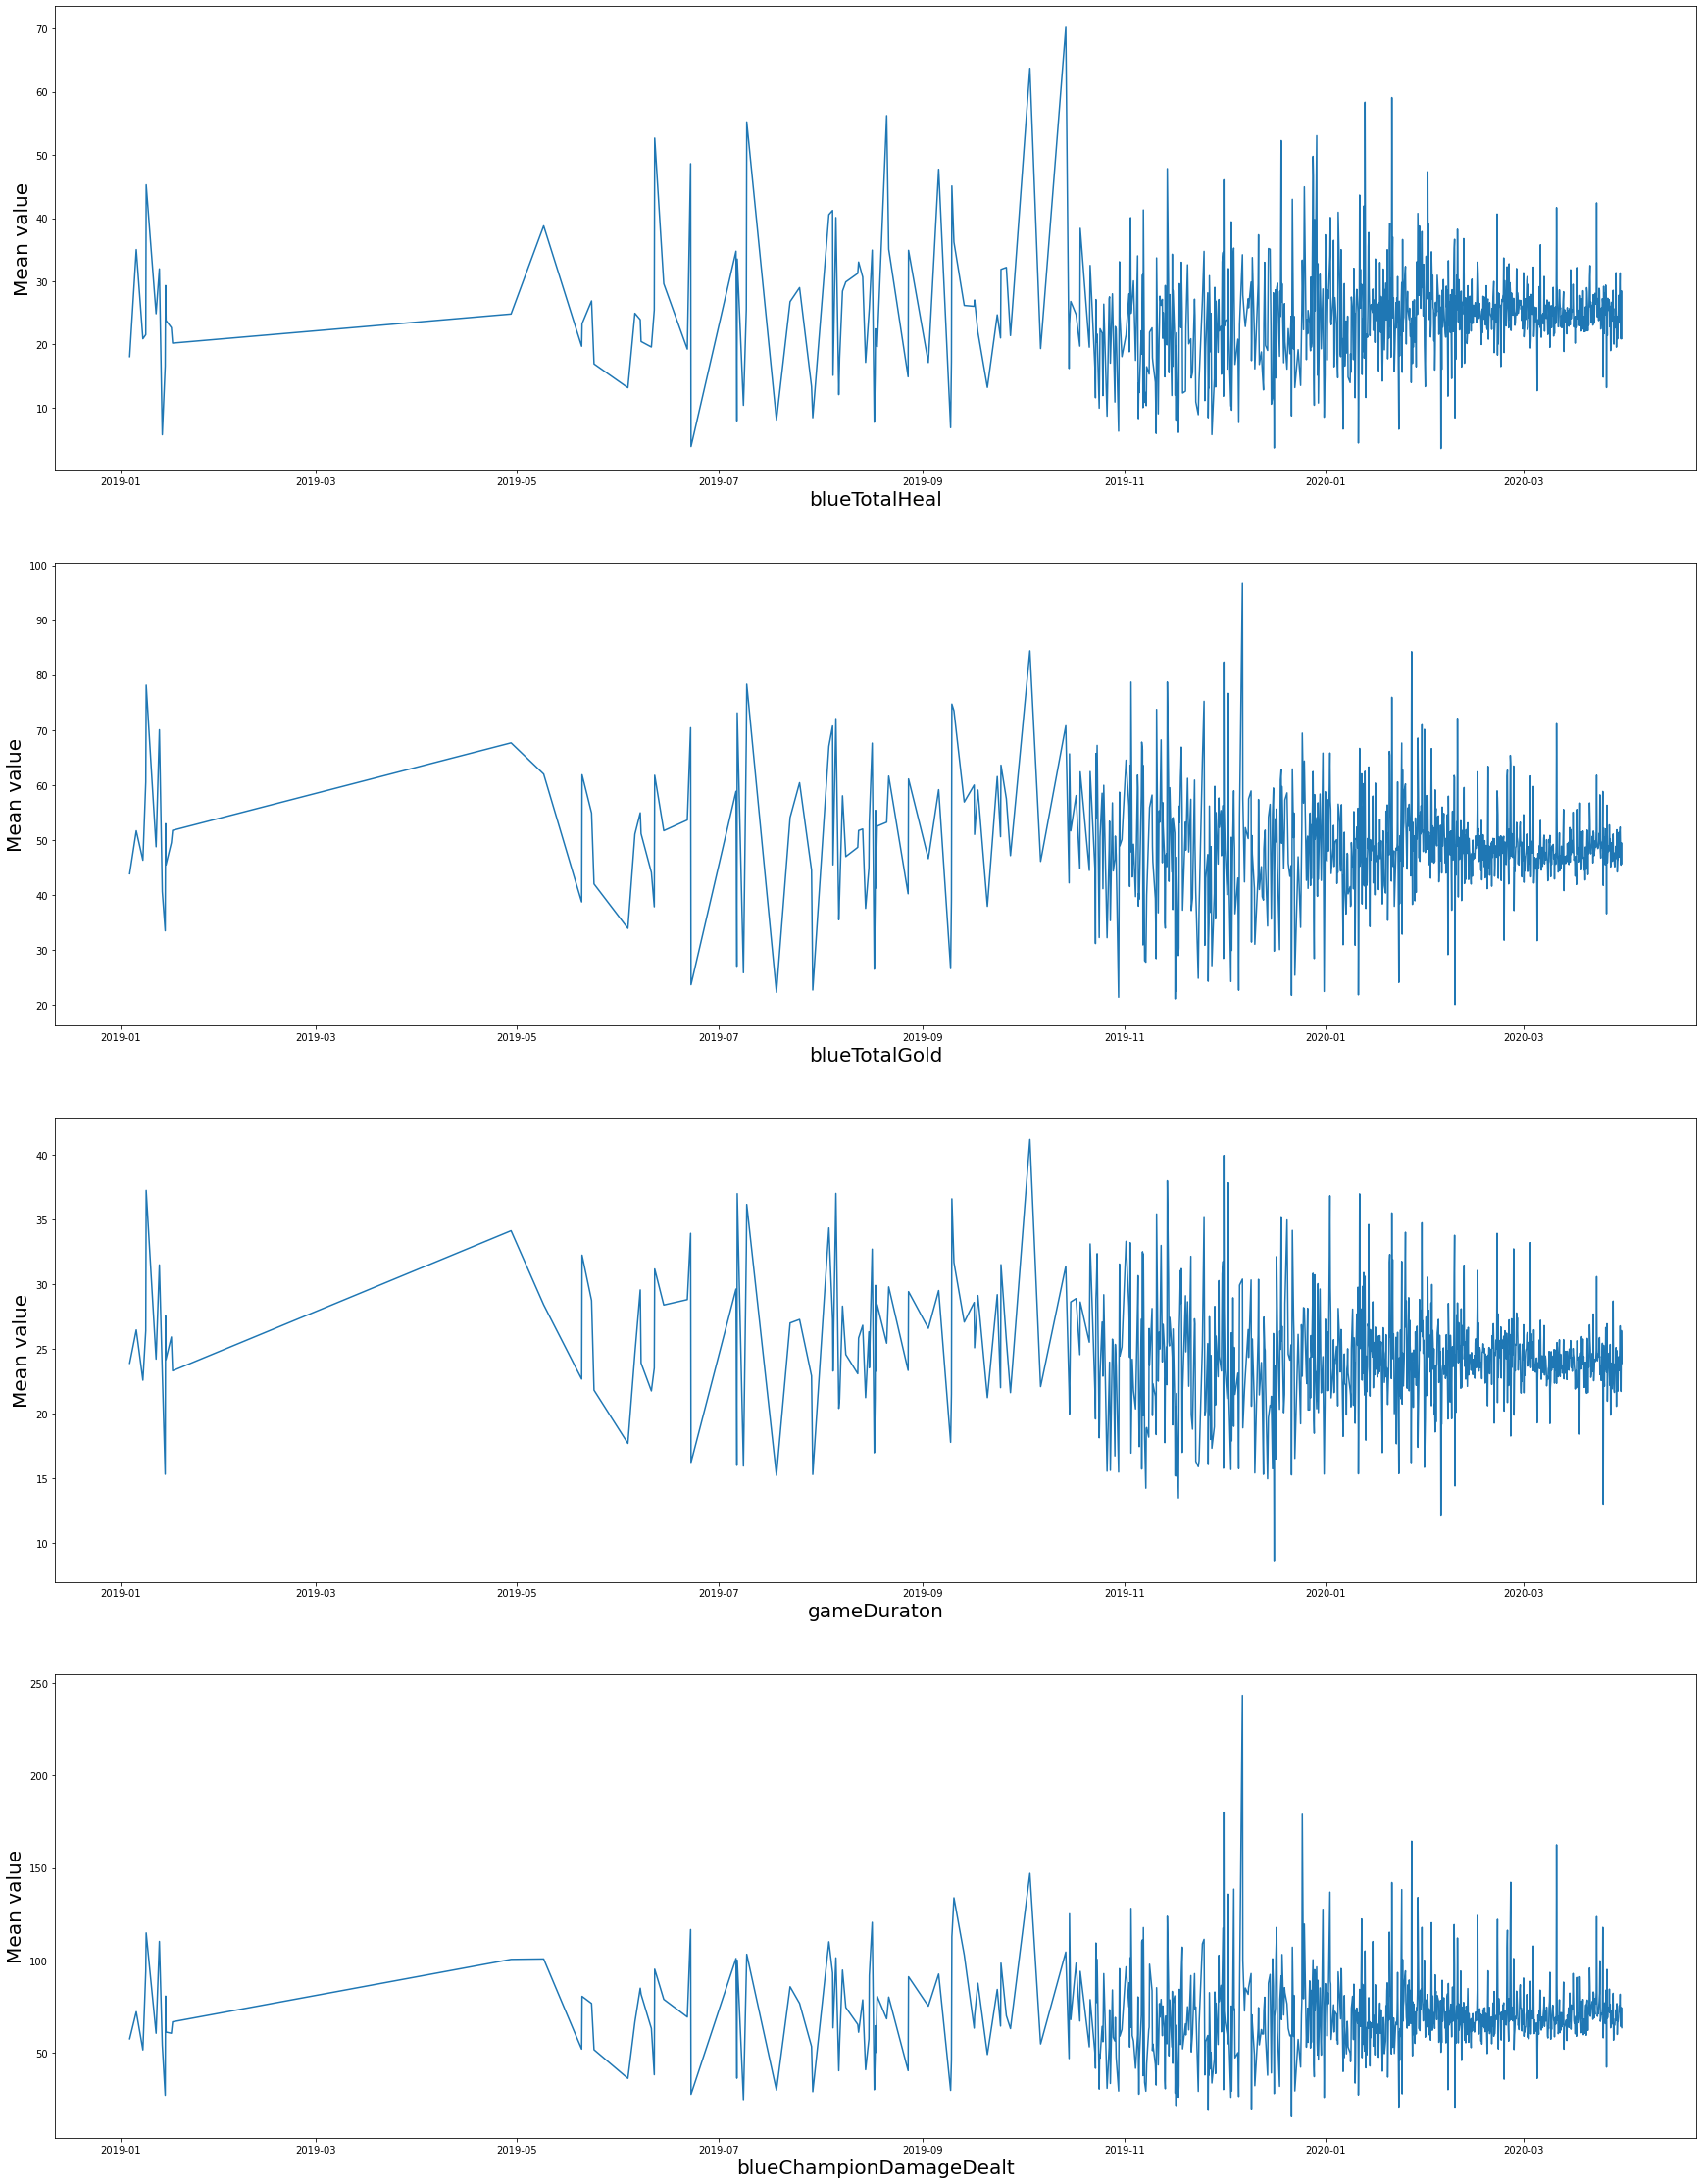

In [97]:

# Show processes for all data
fig, axes = plt.subplots(len(col_names), figsize=(30, 10 * len(col_names)))

idx = 0
for col_name in col_names:
    axes[idx].plot(df_agged['timeStamp'],df_agged[col_name])

    axes[idx].set_xlabel(col_name, fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)

    idx += 1


## Exercise №2

Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

696


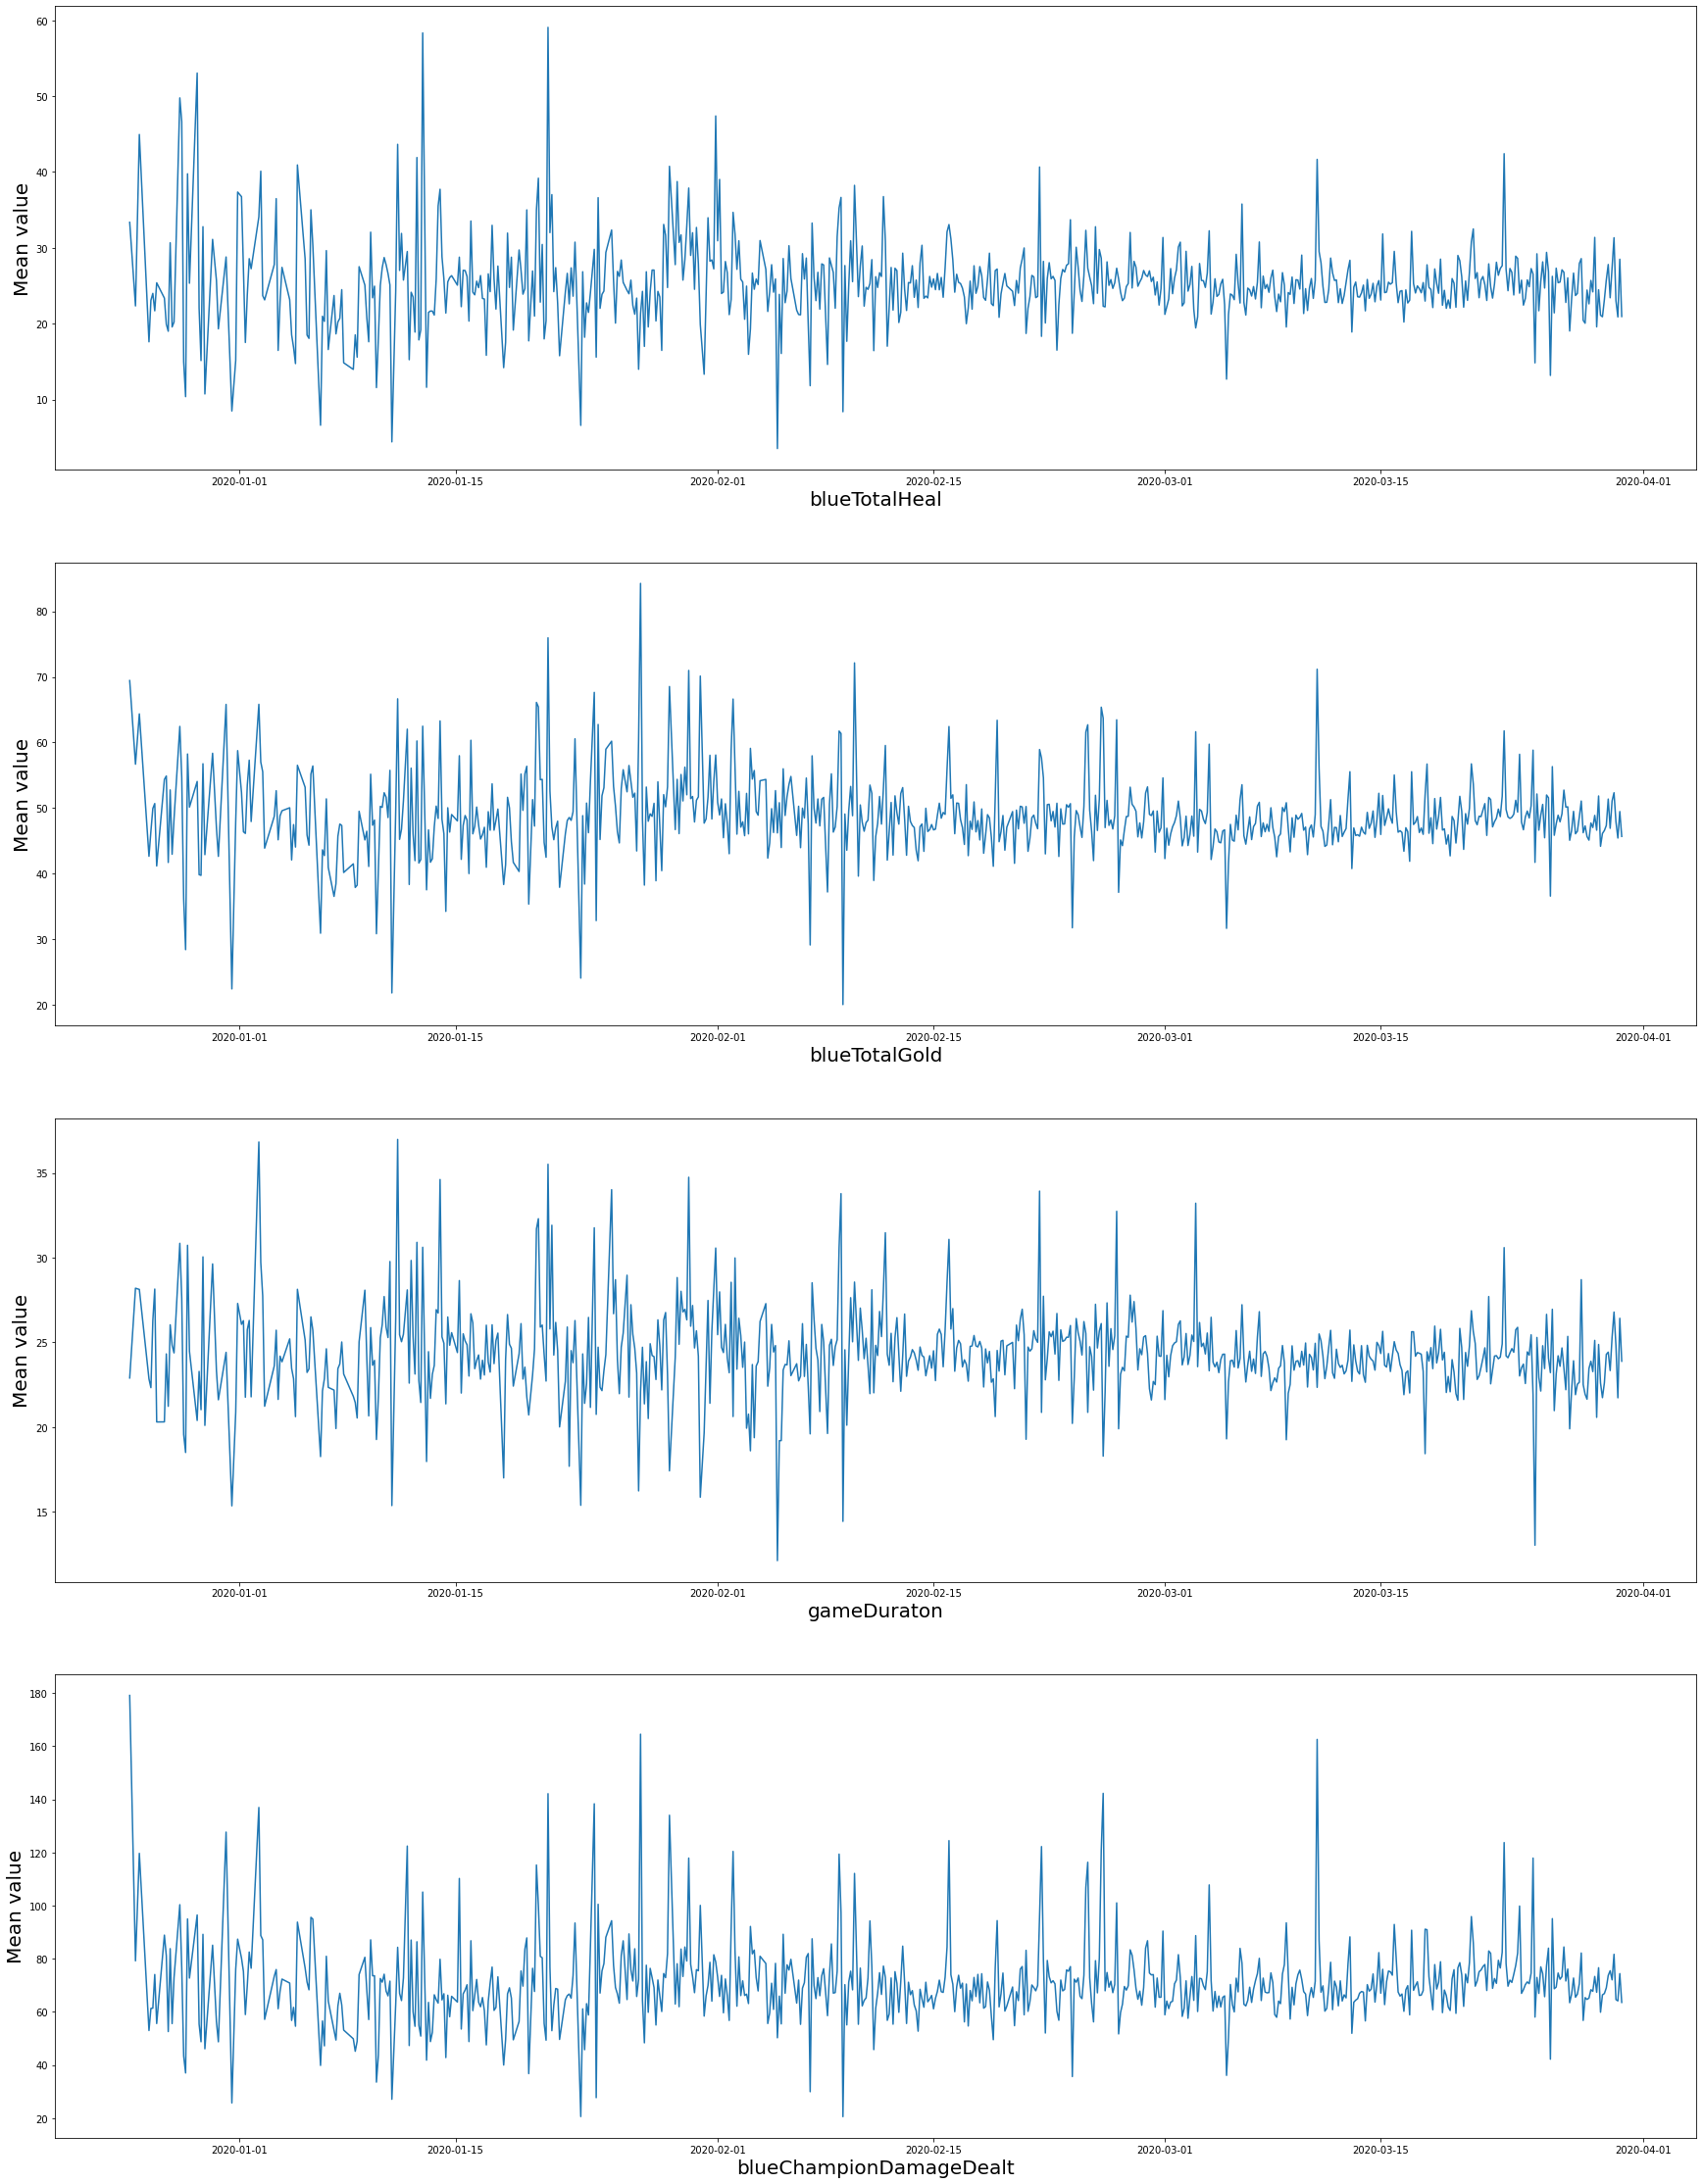

In [111]:
# Make proccess more Stationary
# Remove first sparce part from aggregeted data
drop_part = 300
df_stat = df_agged.drop(df_agged.head(drop_part).index, inplace=False)
print(len(df_stat))
fig, axes = plt.subplots(len(col_names), figsize=(30, 10 * len(col_names)))

idx = 0
for col_name in col_names:
    axes[idx].plot(df_stat['timeStamp'],df_stat[col_name])

    axes[idx].set_xlabel(col_name, fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)

    idx += 1

In [126]:
# Test for Stationarity
for col_name in col_names:
    print("------------------------------", col_name, "--------------------------------")
    result = smt.stattools.adfuller(df_stat[col_name], regression="ct")
    print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))
    sign_lvl = 0.05
    if result[1] < sign_lvl:
        print("STATIONARY")
    else:
        print("NON-STATIONARY")
    print("--------------------------------------------------------------------------------")


------------------------------ blueTotalHeal --------------------------------
Augmented Dickey-Fuller test:
Statistic value = -7.840934
p-value = 0.000000
STATIONARY
--------------------------------------------------------------------------------
------------------------------ blueTotalGold --------------------------------
Augmented Dickey-Fuller test:
Statistic value = -6.731542
p-value = 0.000000
STATIONARY
--------------------------------------------------------------------------------
------------------------------ gameDuraton --------------------------------
Augmented Dickey-Fuller test:
Statistic value = -8.429682
p-value = 0.000000
STATIONARY
--------------------------------------------------------------------------------
------------------------------ blueChampionDamageDealt --------------------------------
Augmented Dickey-Fuller test:
Statistic value = -7.442436
p-value = 0.000000
STATIONARY
--------------------------------------------------------------------------------


## Exercise №3

Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

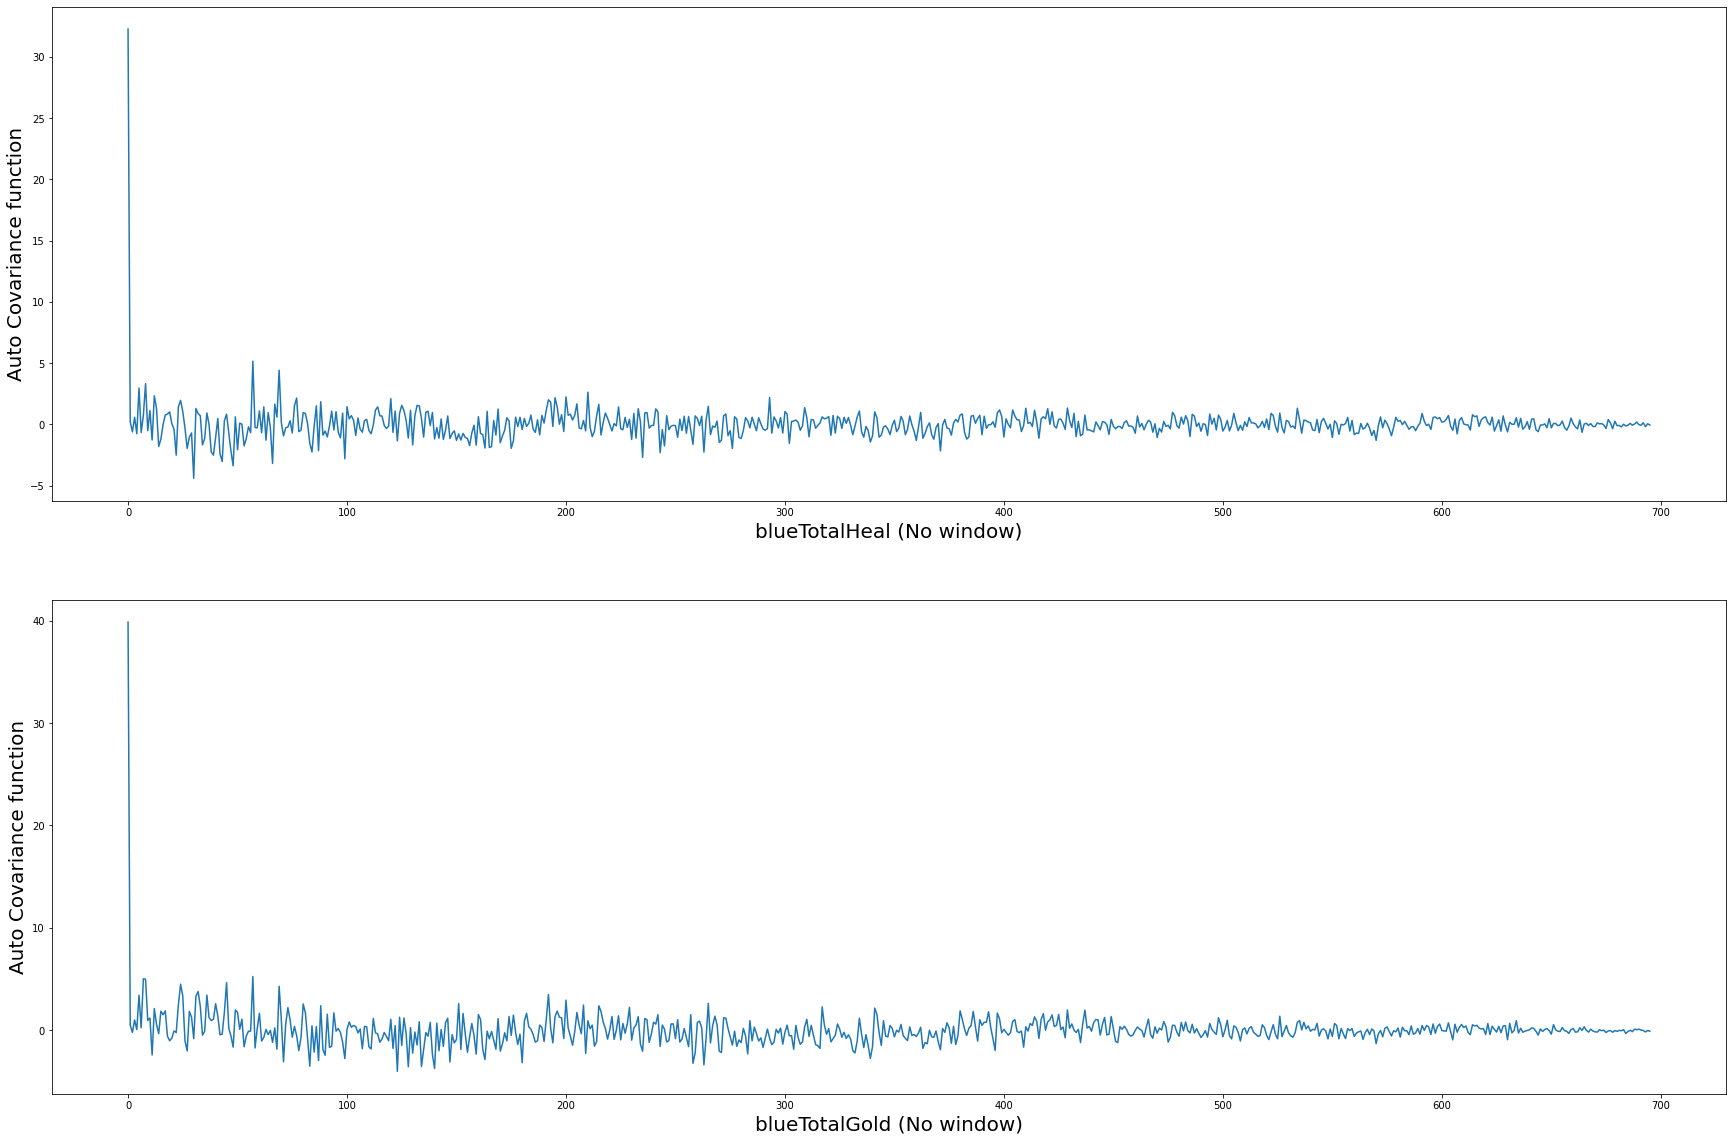

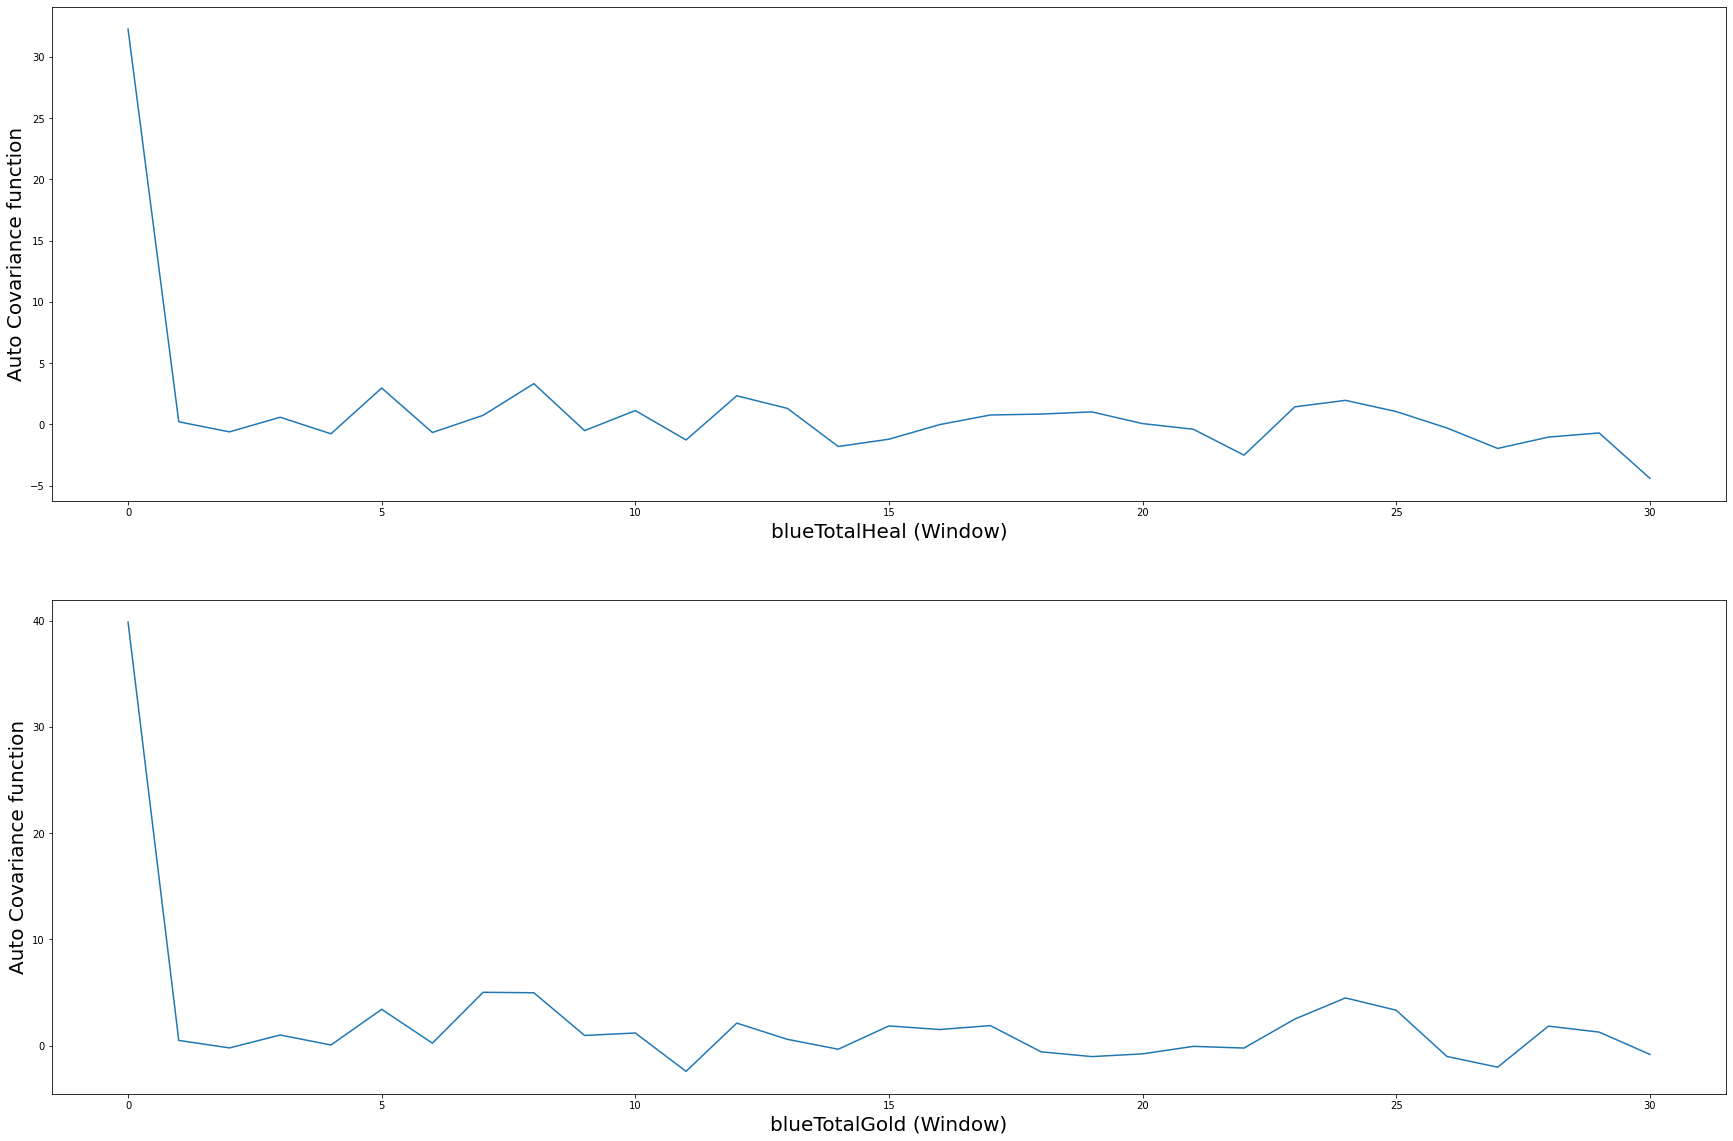

In [204]:
# Analyze auto covariance function (Seems like for stationary processes )

# Autocovariance without window
fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0
for col_name in target_cols:
    axes[idx].plot(stattools.acovf(df_stat[col_name],fft=False)) 
    axes[idx].set_xlabel(col_name+" (No window)", fontsize = 20)
    axes[idx].set_ylabel(u'Auto Covariance function', fontsize = 20)
    idx += 1

# Autocovariance with window
window_size=30
fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0
for col_name in target_cols:
    axes[idx].plot(stattools.acovf(df_stat[col_name], nlag=window_size, fft=False)) 
    axes[idx].set_xlabel(col_name+" (Window)", fontsize = 20)
    axes[idx].set_ylabel(u'Auto Covariance function', fontsize = 20)
    idx += 1

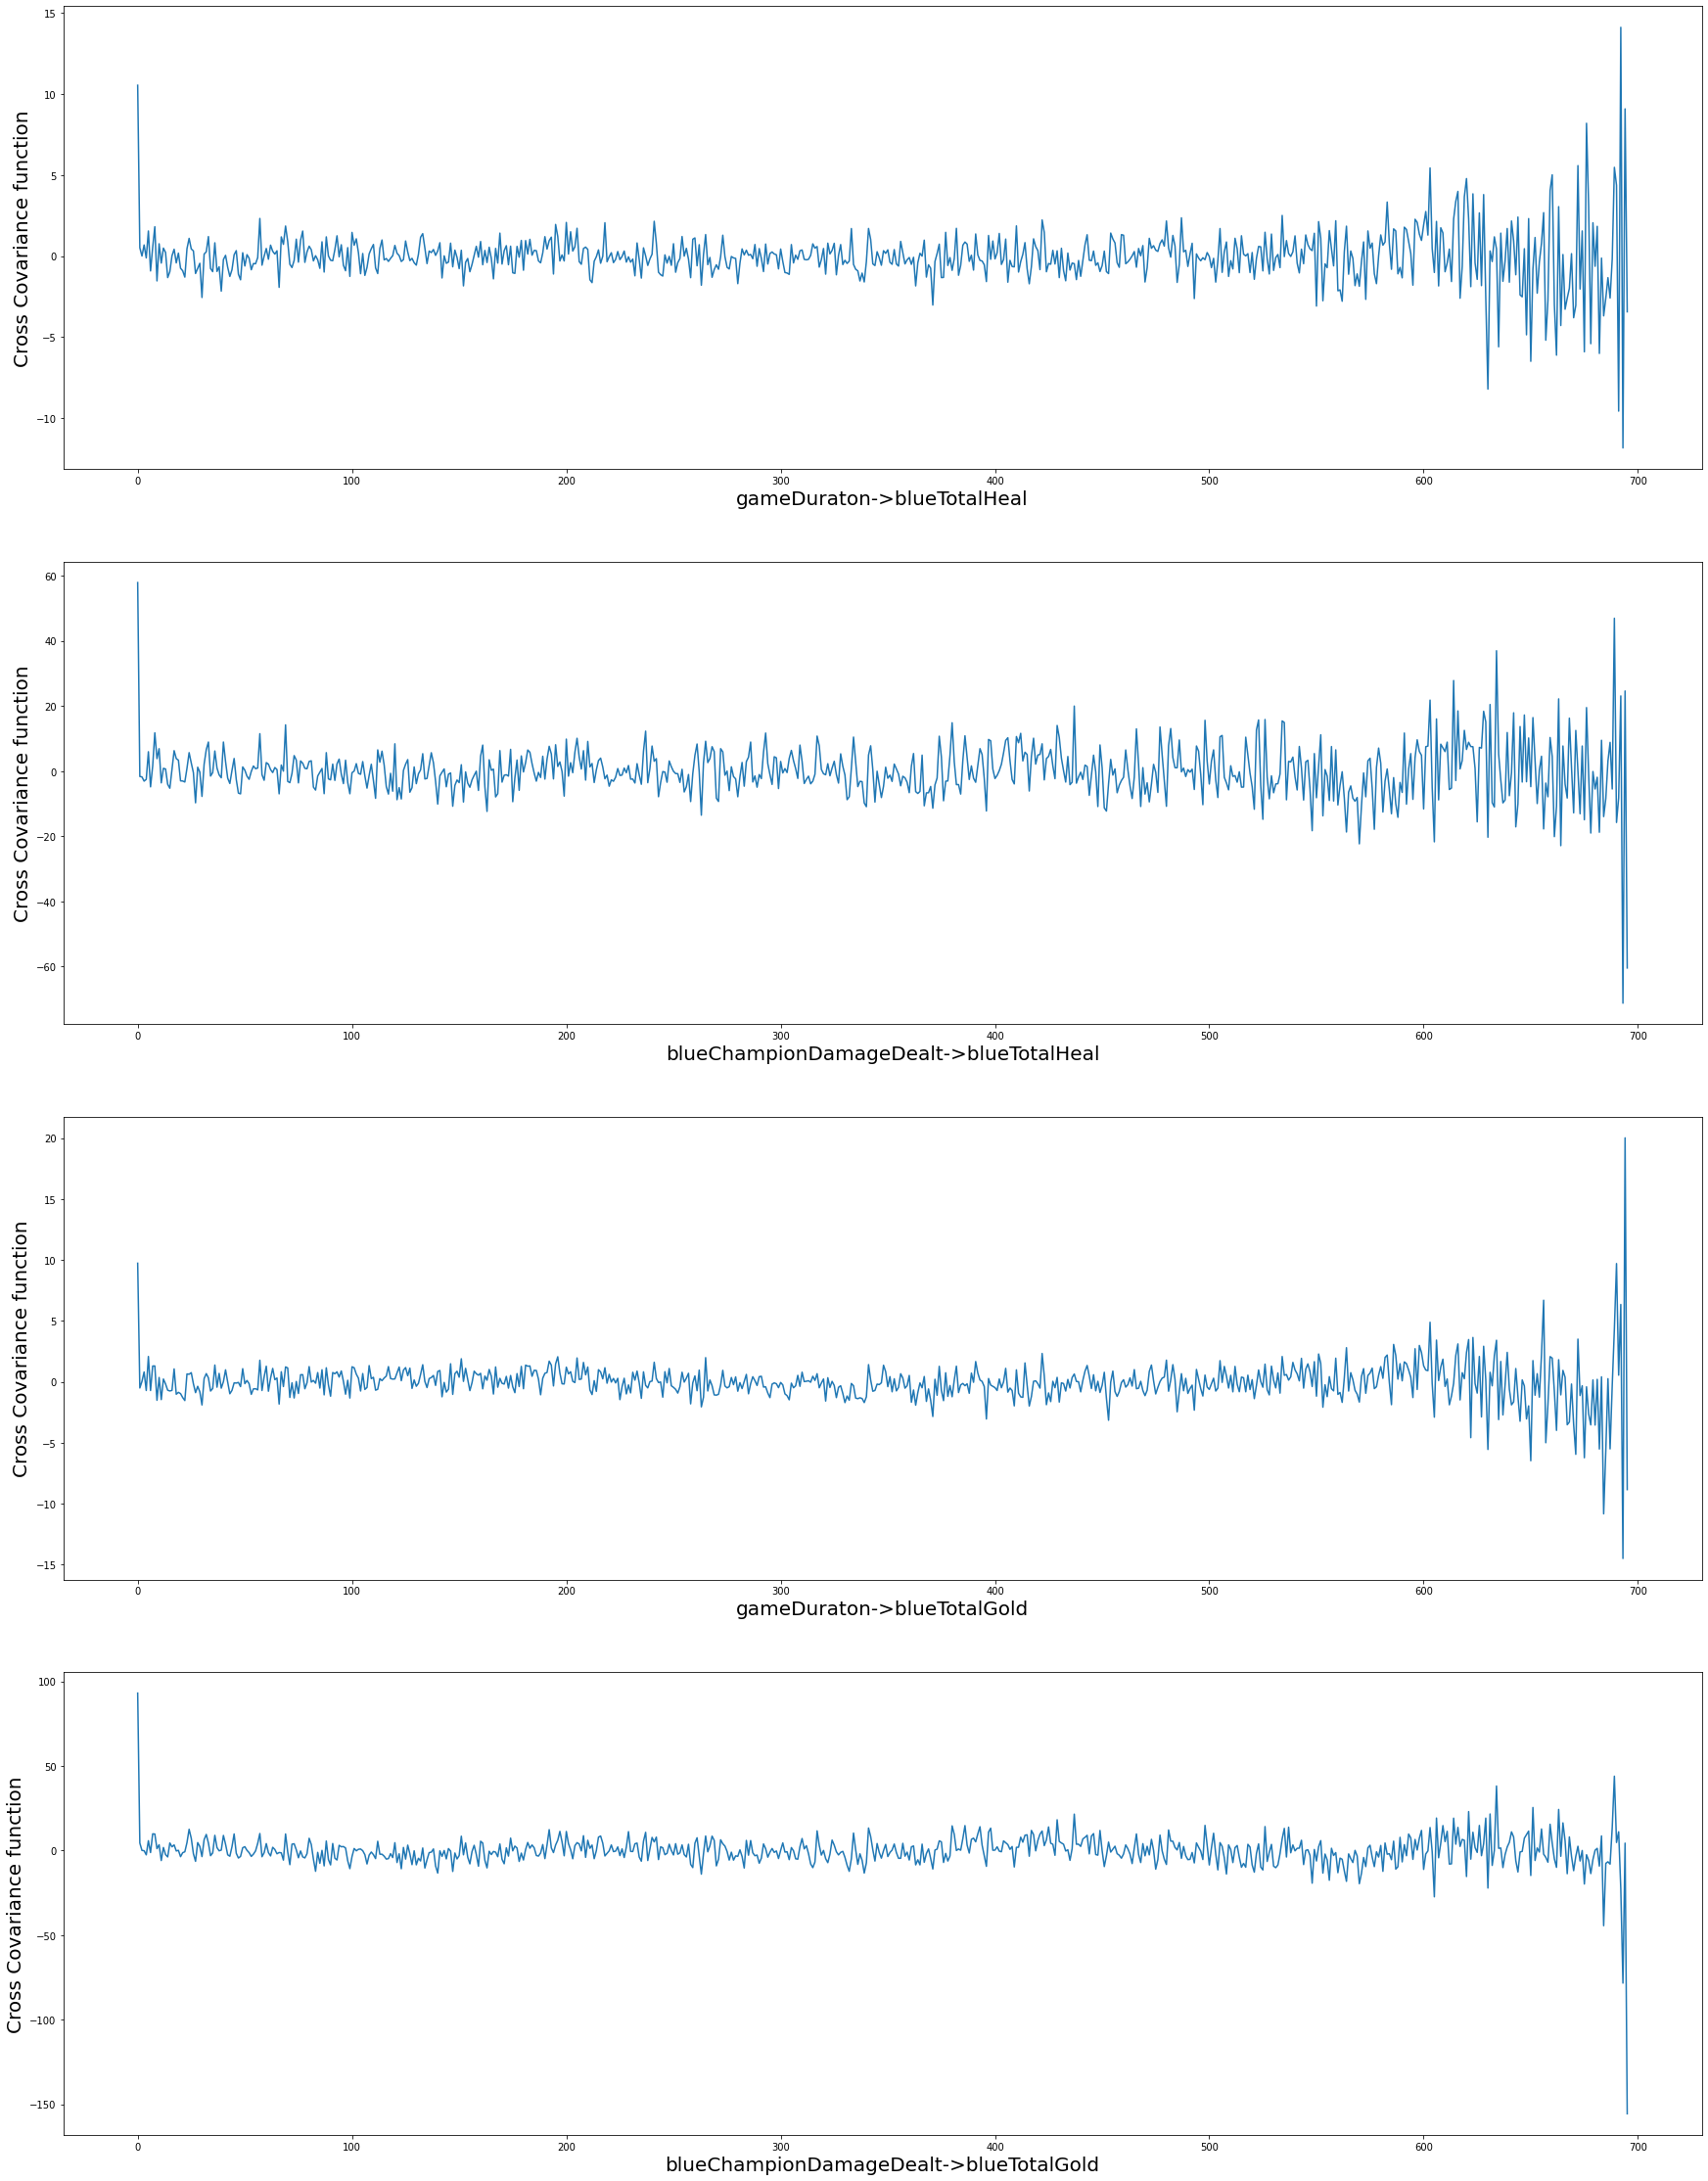

In [144]:
# Analize the cross-covariance between predictor->target 

fig, axes = plt.subplots(len(target_cols)*len(pred_cols), figsize=(30, 10 * len(target_cols) * len(pred_cols)))
idx = 0

for targ_name in target_cols:
    for pred_name in pred_cols:

        axes[idx].plot(stattools.ccovf(x = df_stat[pred_name], y = df_stat[targ_name], fft=False)) 
        axes[idx].set_xlabel(pred_name+'->'+targ_name, fontsize = 20)
        axes[idx].set_ylabel(u'Cross Covariance function', fontsize = 20)
        idx += 1


<AxesSubplot:>

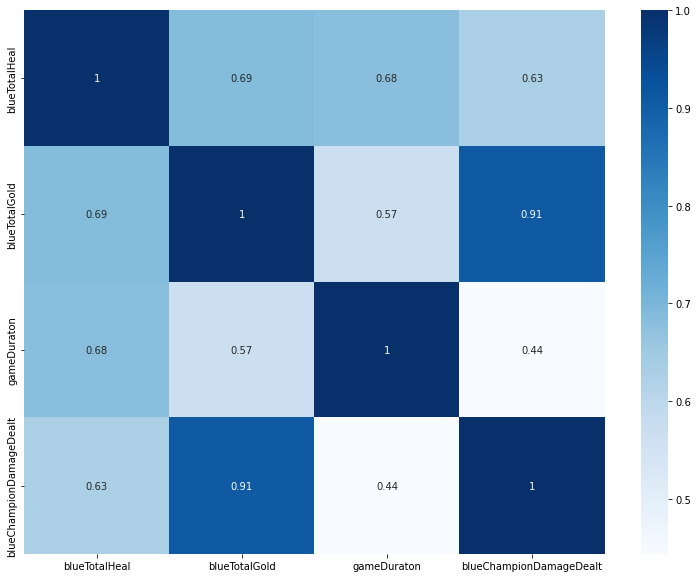

In [151]:
# Show Cross correlation matrix

# Correlation coefficients
fig, axes = plt.subplots(1, 1, figsize=(13, 10))
sns.heatmap(df_stat.corr(), cmap='Blues', annot=True)

## Exercise №4

Filter high frequencies (noise) with chosen 2 filters for target variables

In [171]:
# Prepare data for FEDOT

input_data_list = []

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))

# Convert into numpy array first
for targ_name in target_cols:
    time_series = np.array(df_stat[targ_name])
    input_data = InputData(idx=np.arange(0, len(time_series)),
                        features=time_series, target=time_series,
                        task=task, data_type=DataTypesEnum.ts)

    input_data_list.append(input_data)

    

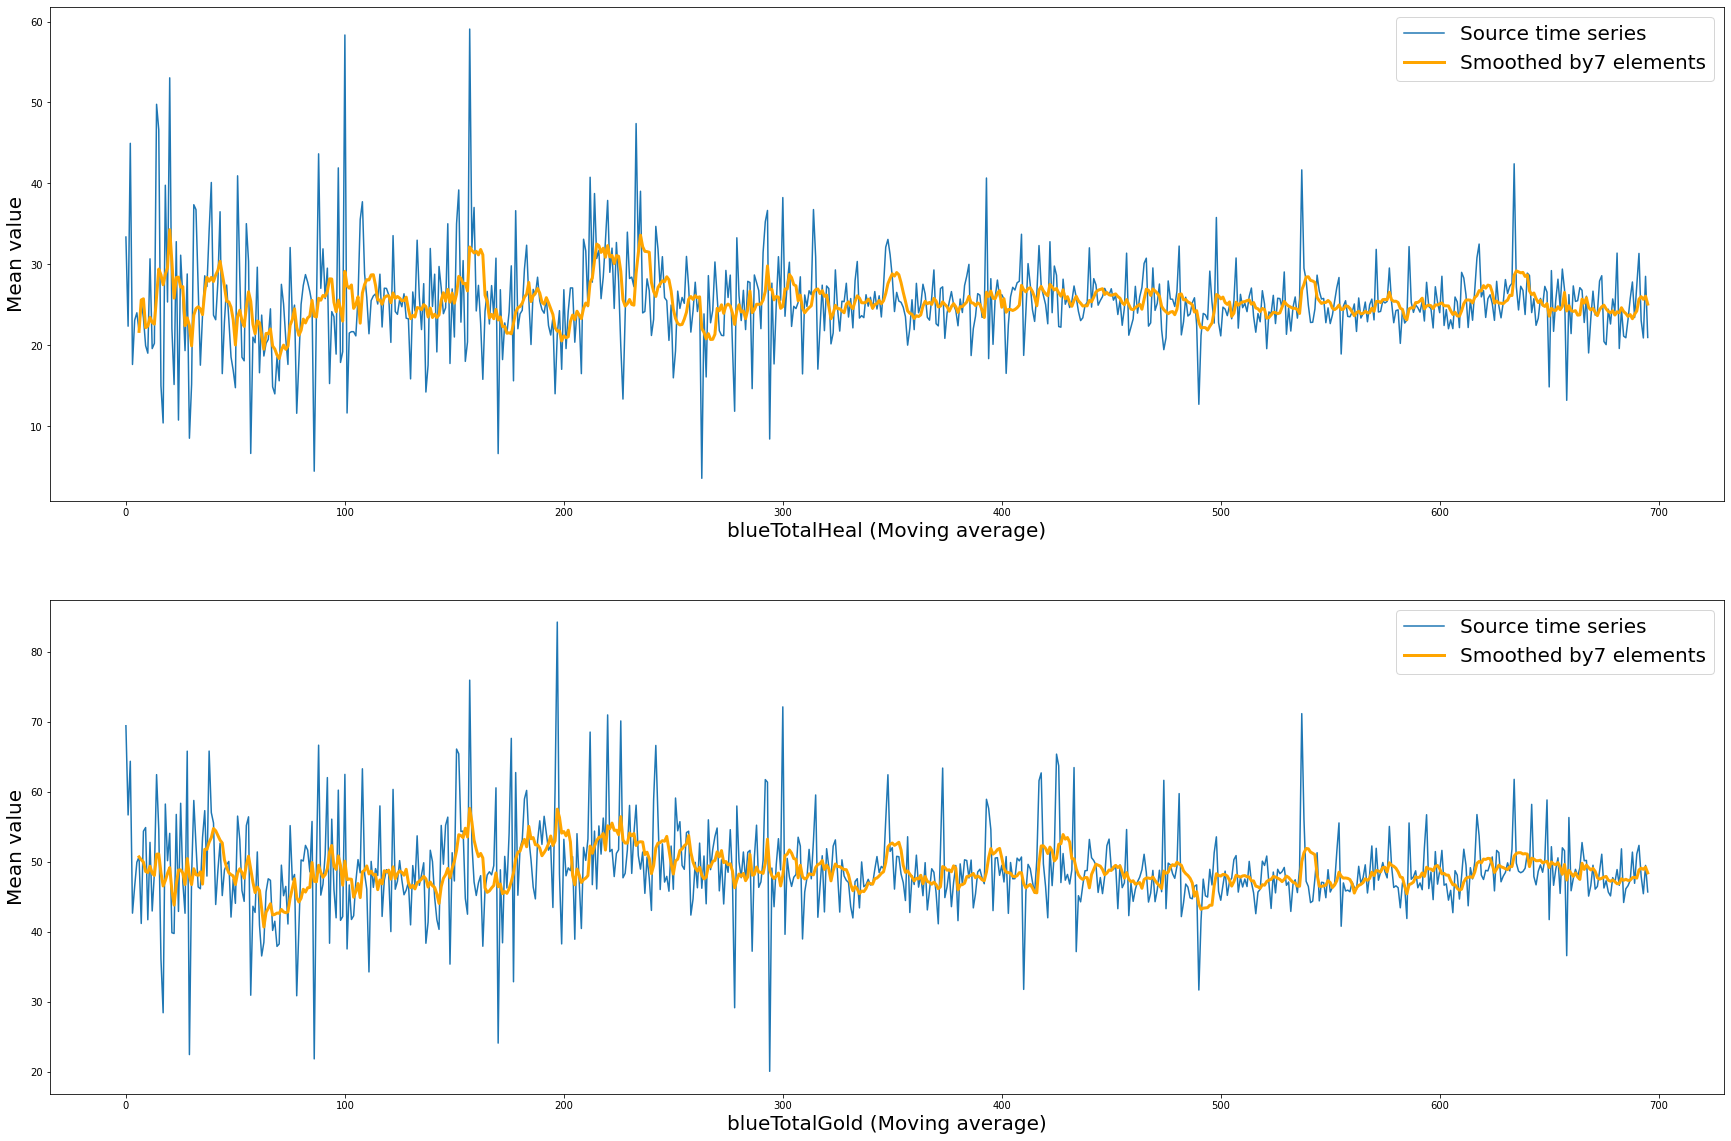

In [226]:
# Moving average filter 

window_size = 7

smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': window_size}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

roll_filt_targs = []

fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0

for col_name in target_cols:
    smoothed_output = node_fit_predict(smoothing_node, input_data_list[idx])
    roll_filt_targs.append(smoothed_output.predict[window_size-1:]) # Cut First elements, that coinside with pure data (input)

    axes[idx].plot(input_data_list[idx].idx, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(smoothed_output.idx[window_size-1:], smoothed_output.predict[window_size-1:], label='Smoothed by'+str(window_size)+' elements', c="orange", linewidth=3)
    axes[idx].set_xlabel(col_name+" (Moving average)", fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)
    axes[idx].legend(fontsize=20)
    idx += 1


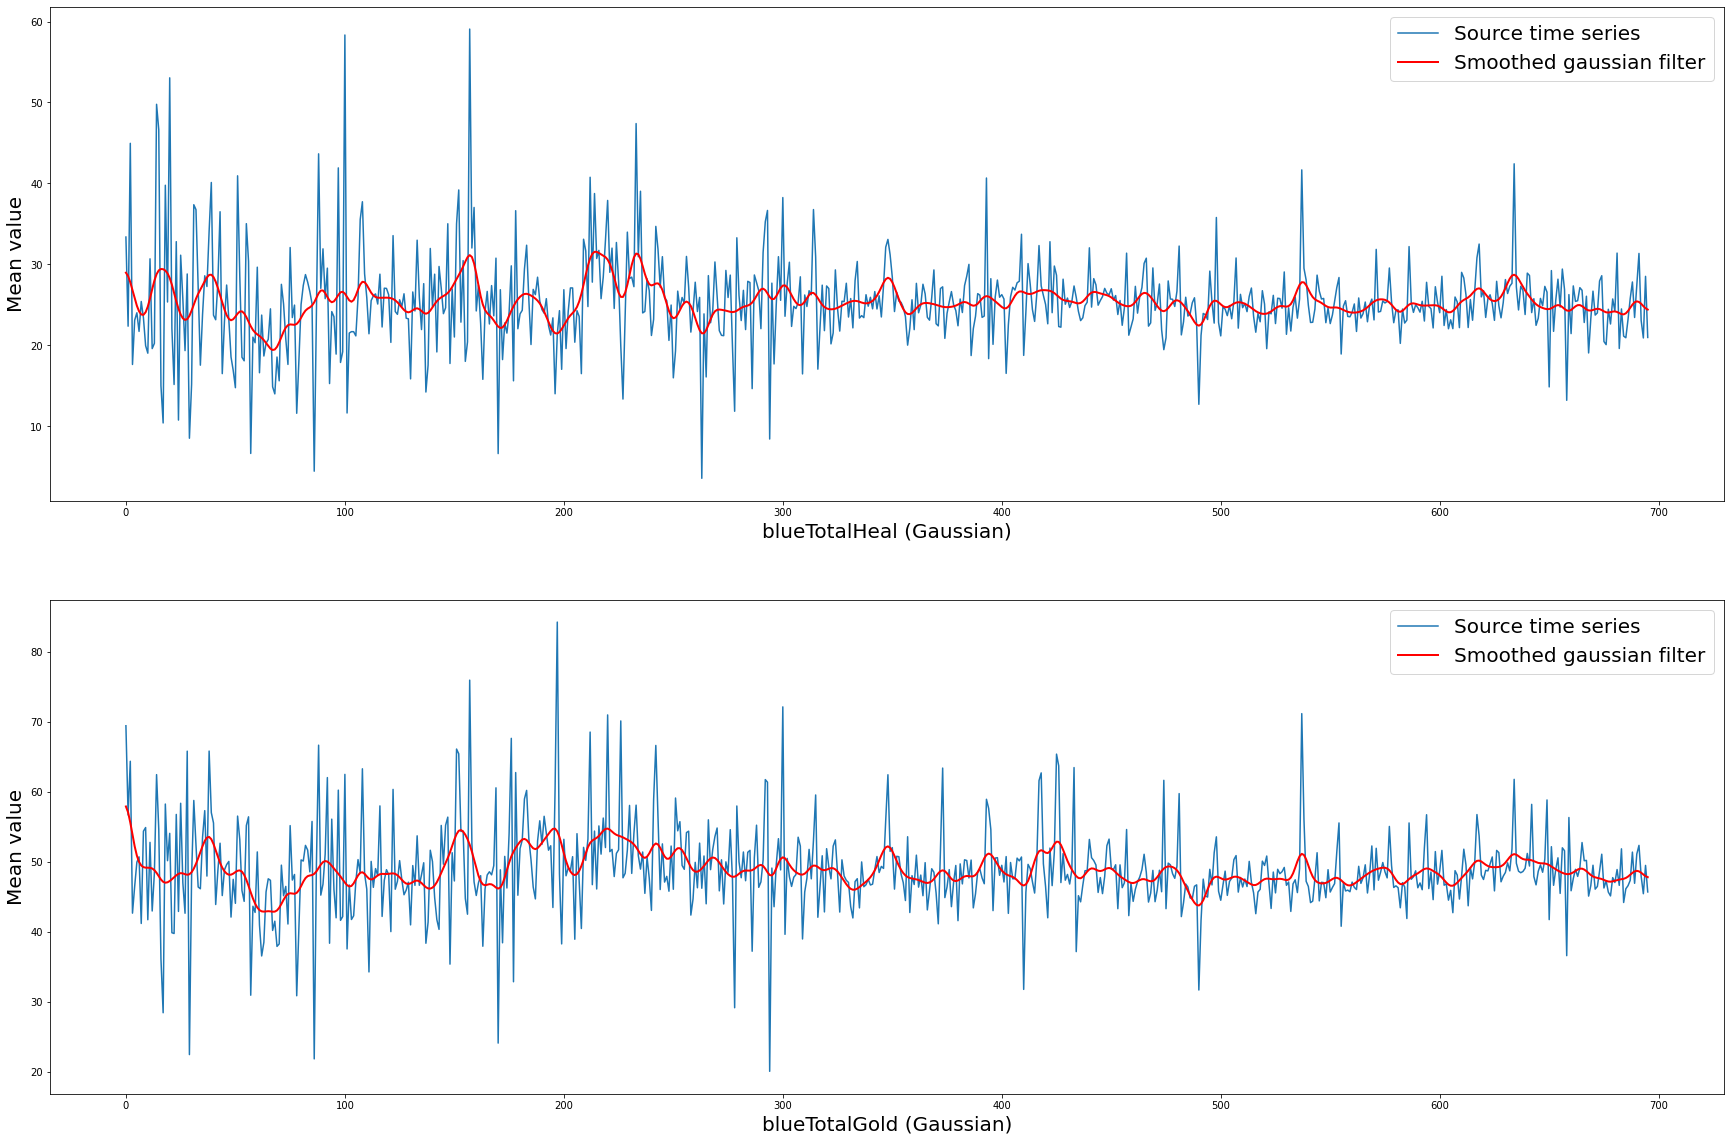

In [222]:
# Gaussian filter

gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 3}

# Prepare data for spectral analisys
gaus_filt_targs = []
pure_targs = []

fig, axes = plt.subplots(len(target_cols), figsize=(30, 10 * len(target_cols)))
idx = 0

for col_name in target_cols:
    smoothed_gaussian = node_fit_predict(gaussian_node, input_data_list[idx])
    gaus_filt_targs.append(smoothed_gaussian.predict)
    pure_targs.append(input_data_list[idx].target)
    axes[idx].plot(input_data_list[idx].idx, input_data_list[idx].target, label='Source time series')
    axes[idx].plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
    axes[idx].set_xlabel(col_name+" (Gaussian)", fontsize = 20)
    axes[idx].set_ylabel(u'Mean value', fontsize = 20)
    axes[idx].legend(fontsize=20)
    idx += 1

## Exercise 5

Estimate spectral density function for with and without filtering

C:\Users\vando\AppData\Local\Temp/ipykernel_4380/1701935994.py:5: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  bartlett = signal.hanning(M=window_size)


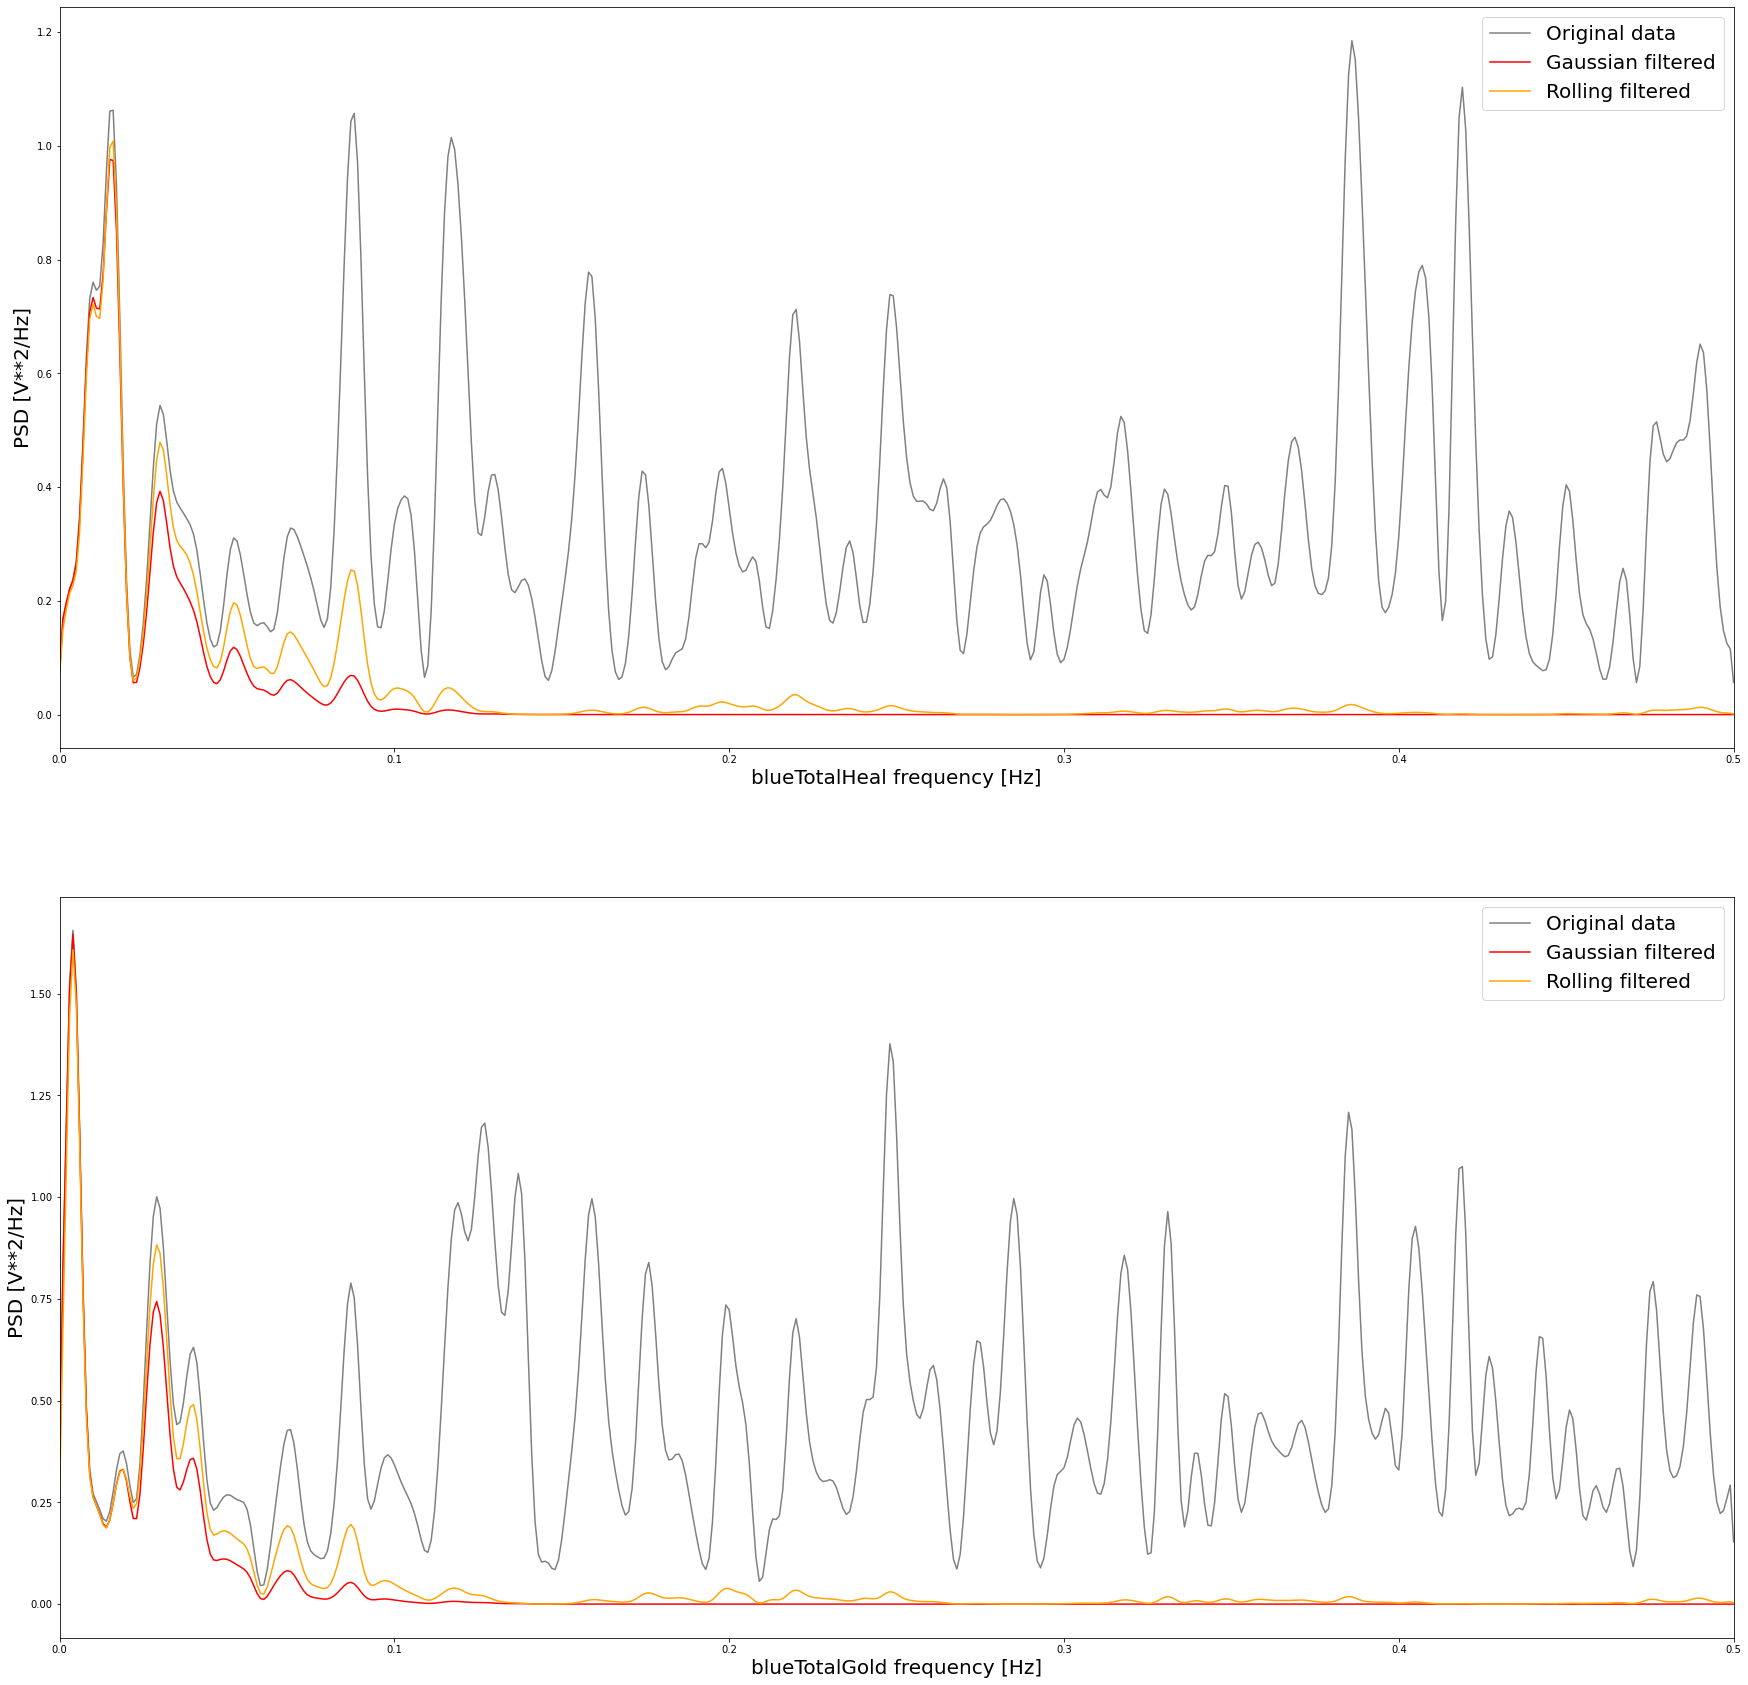

In [229]:
# Plot spectrum for pure and filtered data

window_size = 72
blackman = signal.blackman(M=window_size)
bartlett = signal.hanning(M=window_size)

col_idx = 0

fig, axes = plt.subplots(len(target_cols), figsize=(30, 15 * len(target_cols)))

col_idx = 0
for col_name in target_cols:
    f, Pxx_den = signal.welch(pure_targs[col_idx], fs=1, scaling='spectrum', nfft = 1000) # Spectrum for orig data
    f_flt_g, Pxx_flt_g = signal.welch(gaus_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')
    f_flt_r, Pxx_flt_r = signal.welch(roll_filt_targs[col_idx], fs=1, nfft = 1000, scaling='spectrum')

    axes[col_idx].plot(f, Pxx_den, color="grey", label='Original data')
    axes[col_idx].plot(f_flt_g, Pxx_flt_g, color="red", label='Gaussian filtered')
    axes[col_idx].plot(f_flt_r, Pxx_flt_r, color="orange", label='Rolling filtered')

    axes[col_idx].set_xlabel(col_name+' frequency [Hz]', fontsize = 20)
    axes[col_idx].set_ylabel(u'PSD [V**2/Hz]', fontsize = 20)
    axes[col_idx].set_xlim((0,0.5))
    axes[col_idx].legend(fontsize = 20)
    col_idx += 1
